# 3. Оператор Кэнни

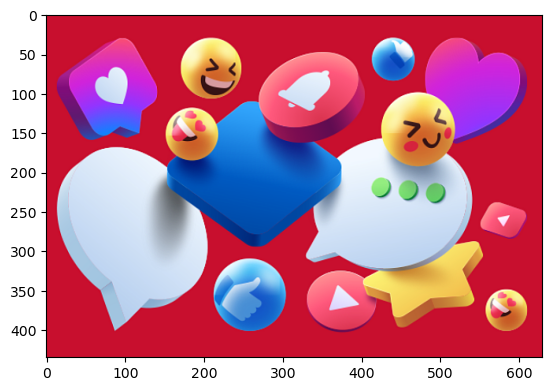

In [122]:
import random
from typing import Union

from PIL import Image
from matplotlib.pyplot import figure, imshow, show
import numpy as np
import numpy.typing as npt

def get_image() -> np.array:
    dir = "images/"
    image = Image.open(dir + "example.png")
    image_array = np.array(image)[:, :, :3]
    return image_array


def show_image(array: np.array, mode: Union[str, None] = 'Greys'):
    figure()
    imshow(array, cmap=mode)


show_image(get_image())

## Полутоновое изображение

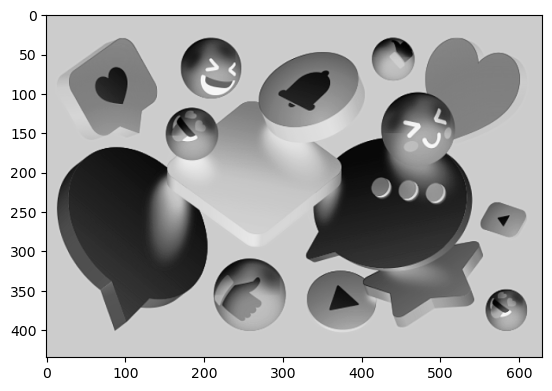

In [123]:
def get_halftone_image() -> np.array:
    image_array = get_image()
    mean = np.mean(image_array, axis=2, dtype=int)
    return mean

show_image(get_halftone_image())

## Шум

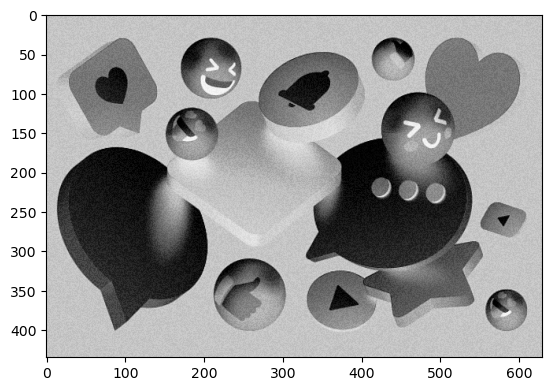

In [124]:
def get_noise_image(mean: float = 50, sigma: float = 5, data_type=float) -> np.array:
    halftone_image_array = get_halftone_image()
    return np.clip(np.array([np.array([pixel + random.gauss(mean, sigma) * random.randint(0, 1) // 3 for pixel in row], dtype=data_type)
                     for row in halftone_image_array]), 0, 255)

show_image(get_noise_image())

## Размытие Гаусса

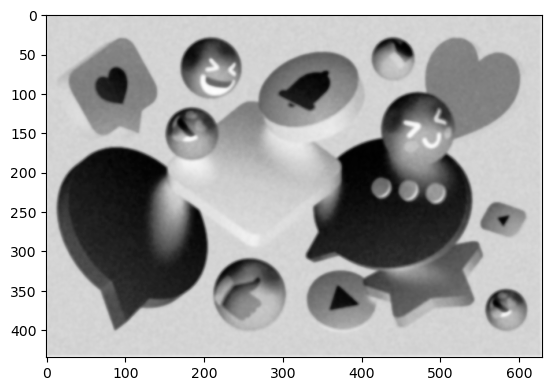

In [125]:
def filter_gauss(K_size, sigma, im):
    H, W = im.shape

    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad: pad + H, pad: pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y: y + K_size, x: x + K_size])
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out[pad: pad + H, pad: pad + W]

show_image(filter_gauss(10, 1.6, get_noise_image()))

## Фильтр Собеля

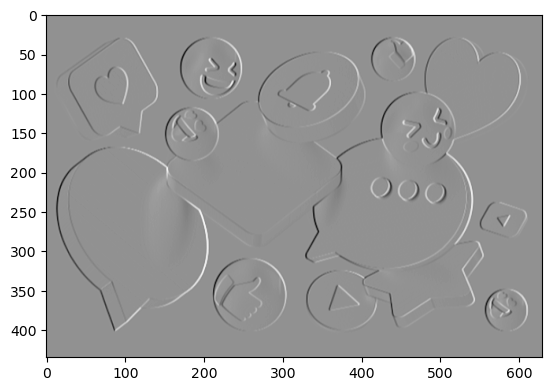

In [126]:
def filter_sobel(image) -> npt.NDArray[list[tuple[int, int]]]:
    H, W = image.shape

    out = np.zeros((H + 2, W + 2, 2), np.float64)
    out[1: 1 + H, 1: 1 + W, 0] = image.copy().astype(np.float64)
    out[0, 0, 0] = out[1, 1, 0]
    out[-1, 0, 0] = out[-2, 1, 0]
    out[0, -1, 0] = out[1, -2, 0]
    out[-1, -1, 0] = out[-2, -2, 0]
    out[1: 1 + H, 0, 0] = out[1: 1 + H, 1, 0]
    out[1: 1 + H, -1, 0] = out[1: 1 + H, -2, 0]
    out[0, 1: 1 + W, 0] = out[1, 1: 1 + W, 0]
    out[-1, 1: 1 + W, 0] = out[-2, 1: 1 + W, 0]

    Mx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
        dtype=int
    )
    My = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ],
        dtype=int
    )
    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[1 + y, 1 + x] = (np.sum(Mx * tmp[y: y + 3, x: x + 3, 0]), np.sum(My * tmp[y: y + 3, x: x + 3, 0]))
    return out[1: 1 + H, 1: 1 + W]


show_image(filter_sobel(get_halftone_image())[:, :, 0])

## Нахождение магнитуд и направлений

In [127]:
def get_magnitude(gradient_matrix: npt.NDArray) -> npt.NDArray[list[int]]:
    return np.sum(abs(gradient_matrix), axis=2)

def get_direction_degrees(gradient_matrix: npt.NDArray) -> npt.NDArray[list[float]]:
    return np.degrees(np.arctan2(gradient_matrix[:, :, 1], gradient_matrix[:, :, 0]))

def get_direction_in_45_step(gradient_matrix: npt.NDArray) -> npt.NDArray[list[int]]:
    degrees_matrix = get_direction_degrees(gradient_matrix)
    return np.rint(degrees_matrix % 360 / 45).astype(int) * 45

# image = get_halftone_image()
# gradient_matrix = filter_sobel(image)
# magnitude = get_magnitude(gradient_matrix)
# direction = get_direction_in_45_step(gradient_matrix)

## Подавление максимумов

In [128]:
def maximum_suppression(magnitude: npt.NDArray[list[float]], direction: npt.NDArray[list[int]]):
    pass

In [129]:
x = np.array([
    [[0, -2], [1, -1]],
    [[-3, 4], [4, np.pi]]
])
np.rint(np.degrees(np.arctan2(x[:, :, 1], x[:, :, 0])) % 360 / 45).astype(int) * 45
# np.degrees(np.arctan2(x[:, :, 1], x[:, :, 0])) % 360
# print(x[:, :, 1].reshape(-1))
# np.degrees(np.arctan(arctan_args)) % 360

array([[270, 315],
       [135,  45]])